In [82]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import gcsfs
from sklearn.model_selection import train_test_split
# conda install -c conda-forge prophet, parce que magie
from prophet import Prophet
from sklearn.impute import KNNImputer


In [3]:
datasets = ["2023-05"]
bucket_name = "prediswiss-parquet-data"

In [4]:
fs_gcs = gcsfs.GCSFileSystem()
dataframes = []
for dataset in datasets:
    path = bucket_name + "/" + dataset + ".parquet"
    table = pq.read_table(path, filesystem=fs_gcs)
    df = table.to_pandas()
    dataframes.append(df)
df = pd.concat(dataframes)

In [31]:
# Specify the parameters
id = 'CH:0542.05'
target = 'flow_11'
date = 'publication_date'

# Filter the DataFrame based on the specified id
filtered_df = df[df['id'] == id].copy()

filtered_df = filtered_df[[date, target]]
filtered_df = filtered_df.sort_values(date)
filtered_df[target] = pd.to_numeric(filtered_df[target], errors='coerce')
filtered_df[date] = pd.to_datetime(filtered_df[date])


In [32]:
filtered_df['flow_11'].fillna(0, inplace=True)
filtered_df.isnull().sum()

publication_date    0
flow_11             0
dtype: int64

In [33]:
filtered_df.reset_index(inplace=True)
filtered_df['index'] = filtered_df.index
filtered_df

,index,publication_date,flow_11
0,0,2023-05-10 10:57:18.254077+00:00,1380.0
1,1,2023-05-10 10:58:18.078285+00:00,1380.0
2,2,2023-05-10 10:59:18.203105+00:00,1260.0
3,3,2023-05-10 11:00:18.063256+00:00,1560.0
4,4,2023-05-10 11:01:18.162343+00:00,1620.0
...,...,...,...
29995,29995,2023-05-31 23:52:18.127738+00:00,120.0
29996,29996,2023-05-31 23:53:18.192065+00:00,60.0
29997,29997,2023-05-31 23:54:18.249585+00:00,120.0
29998,29998,2023-05-31 23:55:18.057492+00:00,0.0


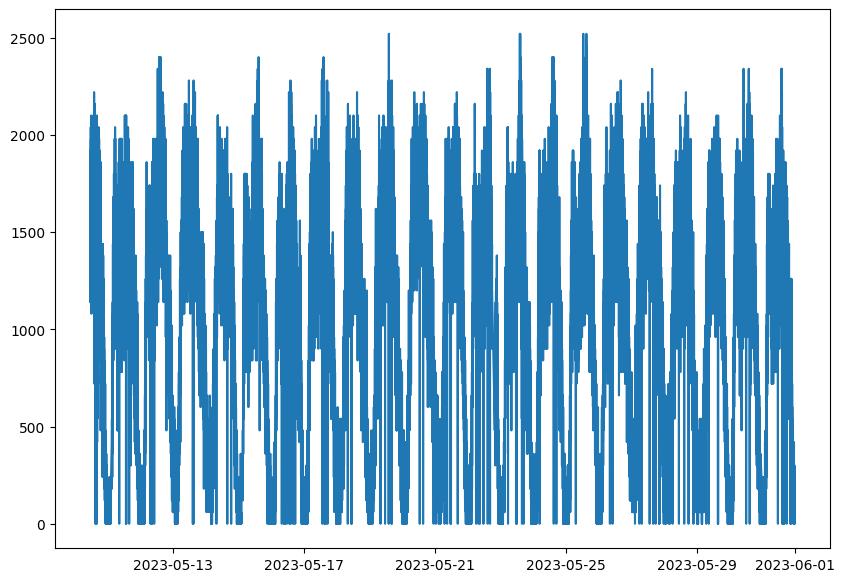

In [34]:
plt.figure(figsize=(10,7))
plt.plot(filtered_df['publication_date'], filtered_df['flow_11'])
plt.show()

In [35]:
filtered_df.index = filtered_df['publication_date']
filtered_df['y'] = filtered_df['flow_11']
filtered_df.drop(columns=['index', 'publication_date', 'flow_11'], axis=1, inplace=True)
filtered_df['ds'] = filtered_df.index
filtered_df['ds'] = filtered_df['ds'].dt.tz_localize(None)

In [98]:
size = 0.3
train, test = train_test_split(filtered_df, test_size=size, shuffle=False)

In [99]:
from prophet import Prophet
model = Prophet()
model.fit(train)

16:43:23 - cmdstanpy - INFO - Chain [1] start processing
16:43:27 - cmdstanpy - INFO - Chain [1] done processing


In [100]:
future = model.make_future_dataframe(periods=len(test), freq='min')
future

,ds
0,2023-05-10 10:57:18.254077
1,2023-05-10 10:58:18.078285
2,2023-05-10 10:59:18.203105
3,2023-05-10 11:00:18.063256
4,2023-05-10 11:01:18.162343
...,...
29991,2023-05-31 20:52:18.111700
29992,2023-05-31 20:53:18.111700
29993,2023-05-31 20:54:18.111700
29994,2023-05-31 20:55:18.111700


In [101]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-05-10 10:57:18.254077,978.430320,1053.268447,1768.034721,978.430320,978.430320,432.165370,432.165370,432.165370,420.982659,420.982659,420.982659,11.182711,11.182711,11.182711,0.0,0.0,0.0,1410.595690
1,2023-05-10 10:58:18.078285,978.468633,1042.092471,1792.012171,978.468633,978.468633,433.077485,433.077485,433.077485,421.844005,421.844005,421.844005,11.233480,11.233480,11.233480,0.0,0.0,0.0,1411.546118
2,2023-05-10 10:59:18.203105,978.507139,1038.894027,1772.814460,978.507139,978.507139,433.991572,433.991572,433.991572,422.707426,422.707426,422.707426,11.284146,11.284146,11.284146,0.0,0.0,0.0,1412.498711
3,2023-05-10 11:00:18.063256,978.545475,1046.393216,1779.300388,978.545475,978.545475,434.907647,434.907647,434.907647,423.572937,423.572937,423.572937,11.334710,11.334710,11.334710,0.0,0.0,0.0,1413.453122
4,2023-05-10 11:01:18.162343,978.583964,1046.474410,1766.424062,978.583964,978.583964,435.825722,435.825722,435.825722,424.440551,424.440551,424.440551,11.385172,11.385172,11.385172,0.0,0.0,0.0,1414.409686


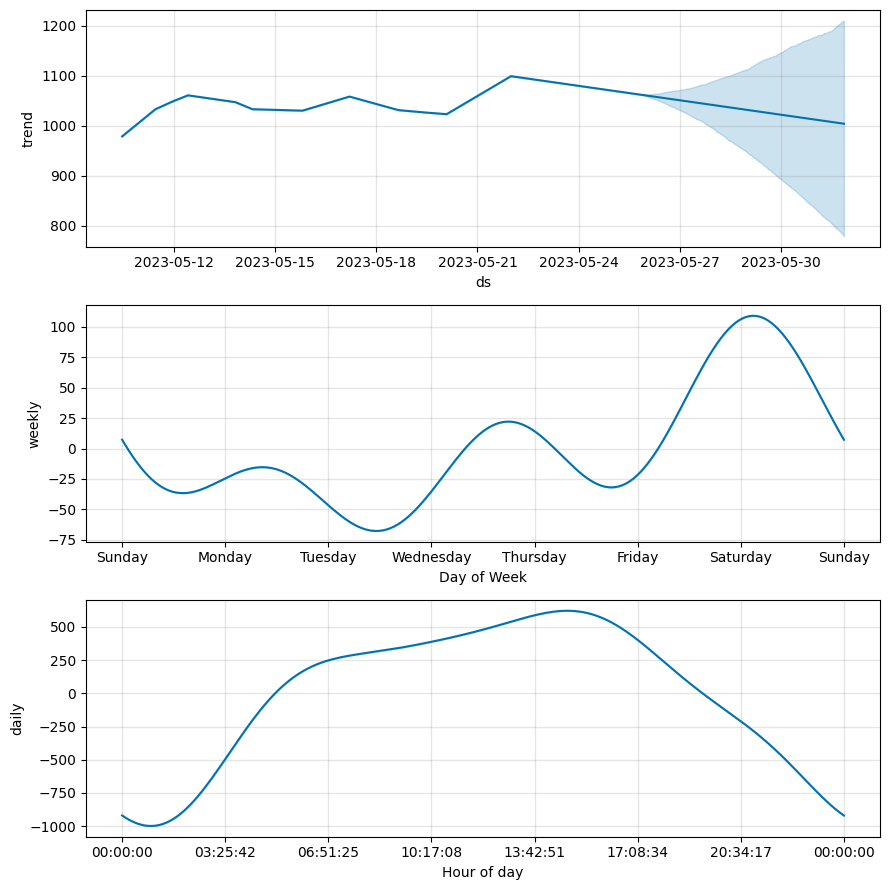

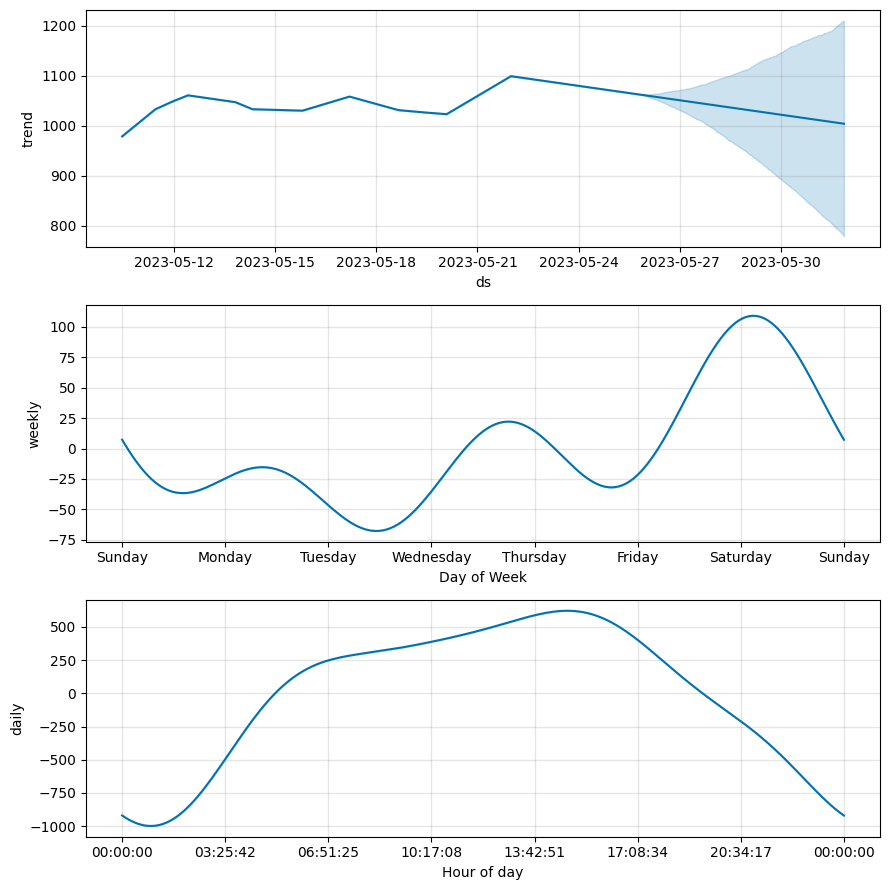

In [102]:
model.plot_components(forecast)

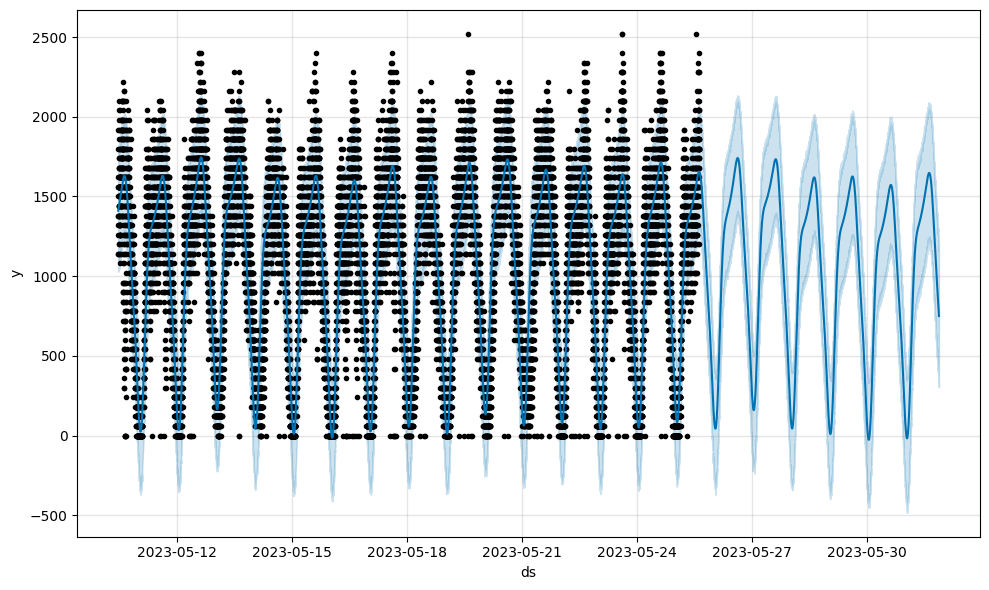

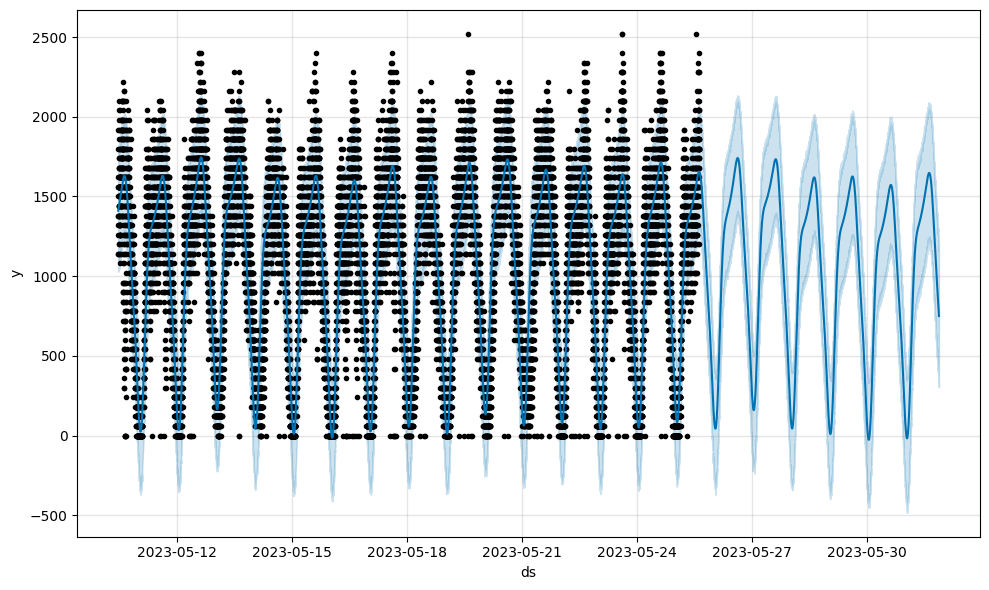

: 

In [103]:
model.plot(forecast)

In [83]:
speed = 'speed_12'
id = 'CH:0542.05'
target = 'flow_11'
date = 'publication_date'
imputer = KNNImputer(n_neighbors=2, weights="uniform")

state_df = df[df['id'] == id].copy()

state_df = state_df[[date, target, speed]]
state_df = state_df.sort_values(date)
state_df[target] = pd.to_numeric(state_df[target], errors='coerce')
state_df[speed] = pd.to_numeric(state_df[speed], errors='coerce')
state_df[date] = pd.to_datetime(state_df[date])
state_df[target] = imputer.fit_transform(state_df[[target]])
state_df[speed] = imputer.fit_transform(state_df[[speed]])
state_df.index = state_df[date]
state_df.drop(columns=['publication_date'], axis=1, inplace=True)

In [84]:
speed_threshold = 40

max_speed = state_df[speed].max()

speed_mapping = {
    120: 120,
    100: 100,
    80: 80,
}

for condition, value in speed_mapping.items():
    if max_speed > condition:
        max_speed = value
        break

print(max_speed)
state_df['state'] = (state_df[speed] > max_speed - speed_threshold) & (state_df[speed].shift().rolling(window=3).sum() != 0) & (state_df[target].shift().rolling(window=3).sum() != 0)
print(state_df.groupby('state').count())
print(state_df[state_df['state'] == False])



120
       flow_11  speed_12
state                   
False      981       981
True     29019     29019
                                  flow_11   speed_12  state
publication_date                                           
2023-05-10 14:00:18.117813+00:00   1320.0  40.700001  False
2023-05-10 14:01:18.191829+00:00    960.0  18.400000  False
2023-05-10 14:02:18.055390+00:00    900.0  18.900000  False
2023-05-10 14:03:18.151702+00:00   1260.0  38.799999  False
2023-05-10 14:04:18.257187+00:00    960.0  25.600000  False
...                                   ...        ...    ...
2023-05-31 16:24:18.062546+00:00   1080.0  30.000000  False
2023-05-31 16:25:18.137360+00:00   1320.0  48.200001  False
2023-05-31 16:26:18.223608+00:00   1440.0  64.300003  False
2023-05-31 16:27:18.037489+00:00   1680.0  70.800003  False
2023-05-31 16:28:18.113331+00:00   1860.0  77.400002  False

[981 rows x 3 columns]


In [85]:
state_df

,flow_11,speed_12,state
publication_date,,,
2023-05-10 10:57:18.254077+00:00,1380.0,98.699997,True
2023-05-10 10:58:18.078285+00:00,1380.0,101.199997,True
2023-05-10 10:59:18.203105+00:00,1260.0,99.500000,True
2023-05-10 11:00:18.063256+00:00,1560.0,103.800003,True
2023-05-10 11:01:18.162343+00:00,1620.0,98.699997,True
...,...,...,...
2023-05-31 23:52:18.127738+00:00,120.0,119.500000,True
2023-05-31 23:53:18.192065+00:00,60.0,119.000000,True
2023-05-31 23:54:18.249585+00:00,120.0,123.500000,True


In [89]:
state_df['y'] = state_df['state']
state_df.drop(columns=[speed, target, 'state'], axis=1, inplace=True)
state_df['ds'] = state_df.index
state_df['ds'] = state_df['ds'].dt.tz_localize(None)

In [92]:
size = 0.3
train, test = train_test_split(state_df, test_size=size, shuffle=False)

In [93]:
from prophet import Prophet
model = Prophet()
model.fit(train)

21:42:19 - cmdstanpy - INFO - Chain [1] start processing
21:42:23 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
future = model.make_future_dataframe(periods=len(test), freq='min')
future

,ds
0,2023-05-10 10:57:18.254077
1,2023-05-10 10:58:18.078285
2,2023-05-10 10:59:18.203105
3,2023-05-10 11:00:18.063256
4,2023-05-10 11:01:18.162343
...,...
29991,2023-05-31 20:52:18.111700
29992,2023-05-31 20:53:18.111700
29993,2023-05-31 20:54:18.111700
29994,2023-05-31 20:55:18.111700


In [96]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-05-10 10:57:18.254077,0.828054,0.656546,1.039171,0.828054,0.828054,0.023673,0.023673,0.023673,0.038492,0.038492,0.038492,-0.014818,-0.014818,-0.014818,0.0,0.0,0.0,0.851727
1,2023-05-10 10:58:18.078285,0.828099,0.649582,1.065257,0.828099,0.828099,0.024422,0.024422,0.024422,0.039208,0.039208,0.039208,-0.014786,-0.014786,-0.014786,0.0,0.0,0.0,0.852522
2,2023-05-10 10:59:18.203105,0.828145,0.642454,1.062594,0.828145,0.828145,0.025166,0.025166,0.025166,0.039919,0.039919,0.039919,-0.014753,-0.014753,-0.014753,0.0,0.0,0.0,0.853310
3,2023-05-10 11:00:18.063256,0.828190,0.646050,1.067166,0.828190,0.828190,0.025903,0.025903,0.025903,0.040623,0.040623,0.040623,-0.014721,-0.014721,-0.014721,0.0,0.0,0.0,0.854093
4,2023-05-10 11:01:18.162343,0.828236,0.650554,1.061693,0.828236,0.828236,0.026634,0.026634,0.026634,0.041322,0.041322,0.041322,-0.014688,-0.014688,-0.014688,0.0,0.0,0.0,0.854869


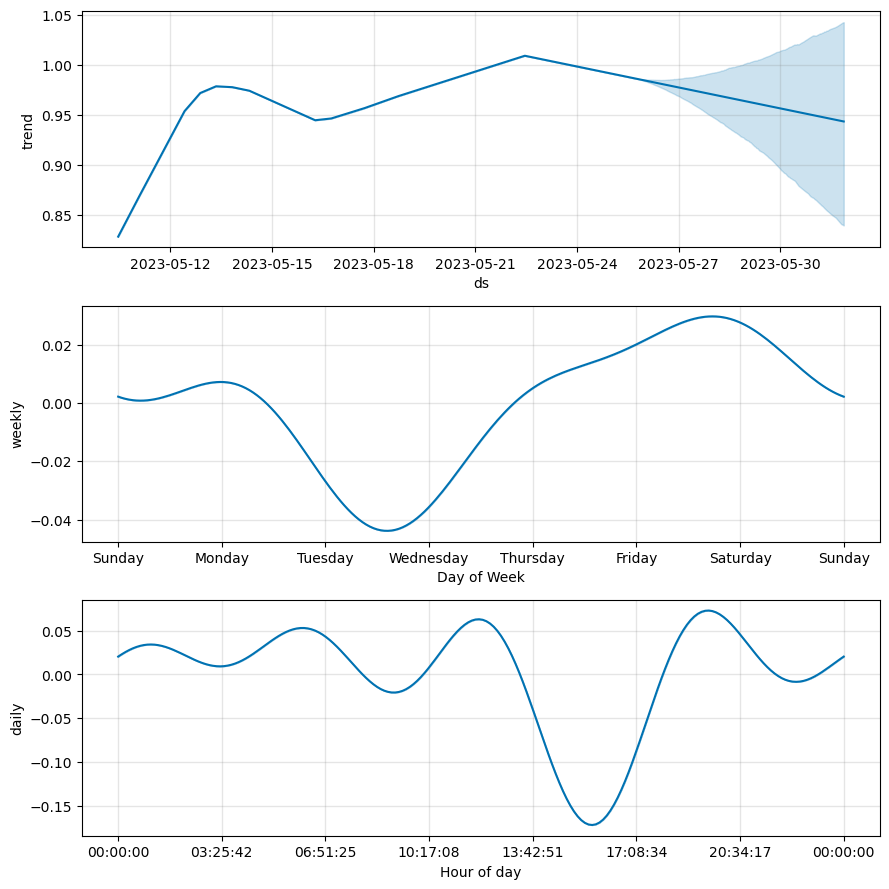

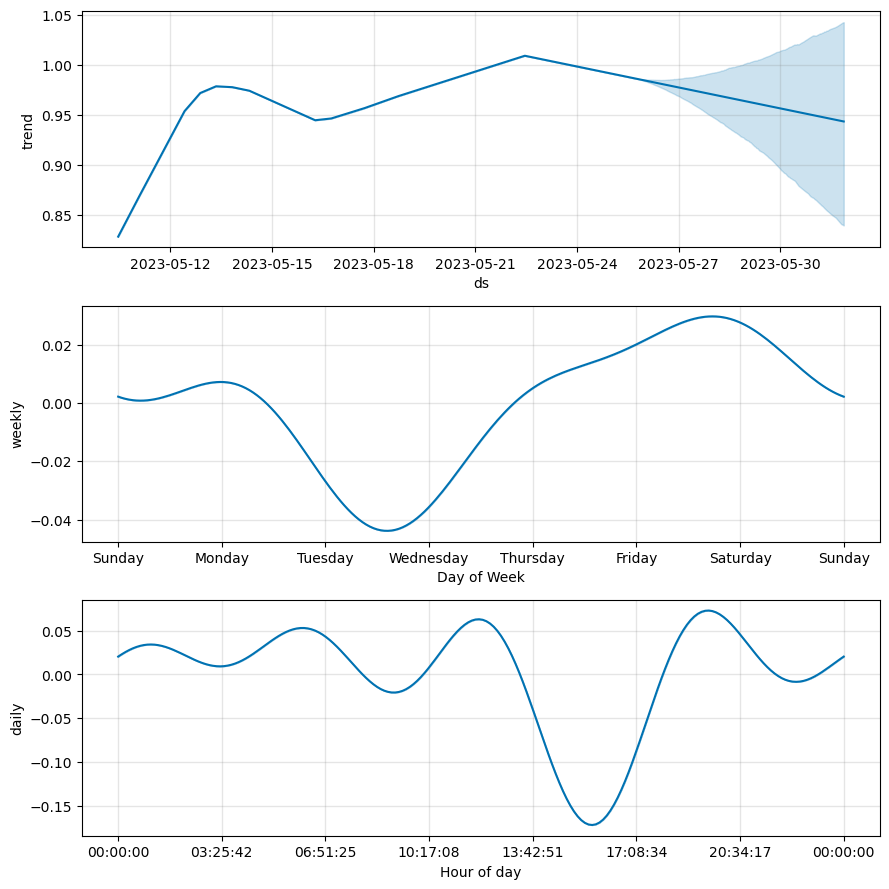

: 

In [98]:
model.plot_components(forecast)

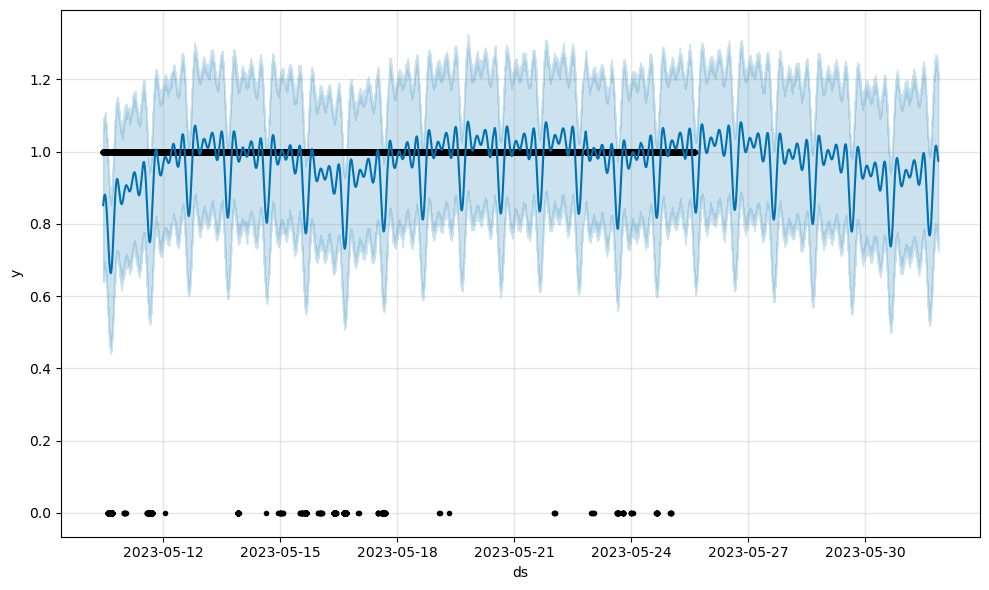

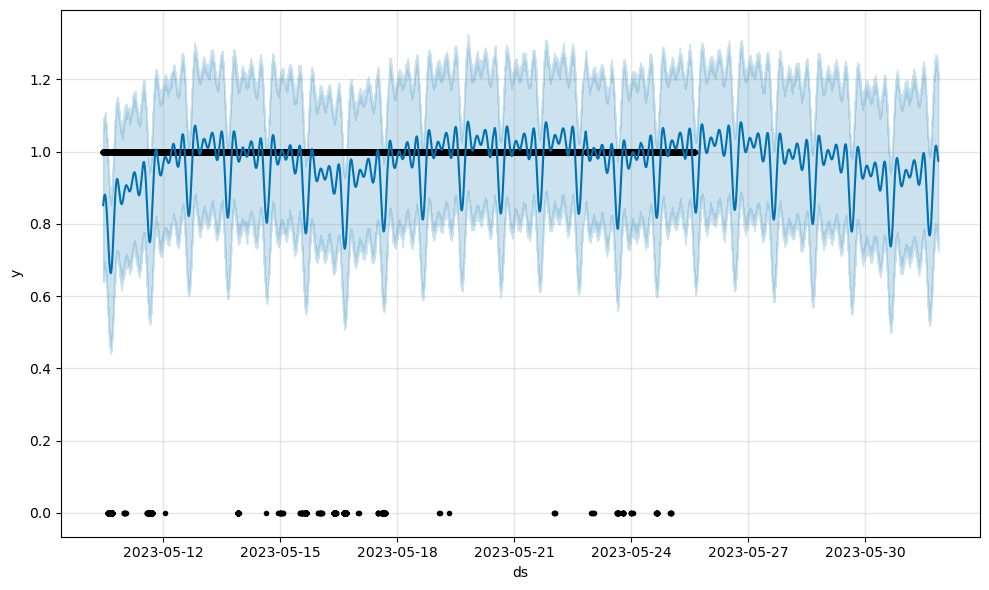

In [97]:
model.plot(forecast)